   # Práctica 3: Mapas de Correlación y Regresion
   En este este cuaderno vas a aprender a calcular mapas de correlación y regresion

## Este cuaderno te guiará para aprender a trabajar con matrices y a representar mapas de correlación y regresión, cuando trabajamos con más de 1 dimensión
Vamos a trabajar con el ejemplo de El Niño, que es el modo de variabilidad climática más importante a escala global. También trabajaremos con la variabilidad pluvial del Sahel, definiendo un índice y representando mapas de correlación y regresión.



In [2]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from scipy.fft import fft 
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import numpy.ma as ma
import time


In [3]:
#MAPA DE CORRELACIÓN ESPACIAL. UN ÍNDICE TEMPORAL (nt,1) y UNA MATRIZ ESPACIO.TIEMPO (ns,nt)
def IndexRegression(Data,Index,alfa):
    [n1,n2]=Data.shape #los datos introducidos en Data tienen que tener dimesión n1=espacio, n2=tiempo 
    #inicializamos las matrices
    Cor=ma.empty([n1,])
    Pvalue=ma.empty([n1,])
    reg=ma.empty([n1,])
    reg_sig=ma.empty([n1,])
    for nn in range(n1): #for each of the points in the space, we calculate the Pearson correlation
        bb=pearsonr(Data[nn,:],Index) #bb has 2 outputs: first if the correlation and seconde is p-value 
        Cor[nn]=bb[0]
        Pvalue[nn]=bb[1]
    #we generate a mask for showing just the significant values
    
    Cor_sig=ma.masked_where(Pvalue>alfa,Cor)
    # we generate the regression map by matrix multiplication
    reg=Data.dot(Index)/ (n2-1)
    #we calculate the mask
    reg_sig=ma.masked_where(Pvalue>alfa,reg)
    return Cor,Pvalue,Cor_sig,reg,reg_sig

En este cuaderno de Jupyter haremos una revisión de los mapas de correlación y de los mapas de regresión
tendremos que utilizar conceptos de análisis univariante
tendremos que utilizar algunos conceptos de análisis estadístico significativo, a partir de nuestros resultados, utilizando funciones de numpy o scipy pero también puedes utilizar funciones Necesitarás lo siguiente

    numpy: para hacer cálculos sobre los datos
    pyplot: para dibujar
    stats de scipy: para alguna métrica estadística y también para el manejo de filtros y transformadas
    Dataset de netCDF: para la lectura de datos en formato netcdf
    De cartopy usamos función add_cyclic_point (para poder pintar la longitud como un continuo)
    De cartopy importmos el módulo ccrs para poder usar diferentes proyecciones
    Importamos time para poder hacer una movie

### si quieres aprender más sobre el ENSO, consulta este video

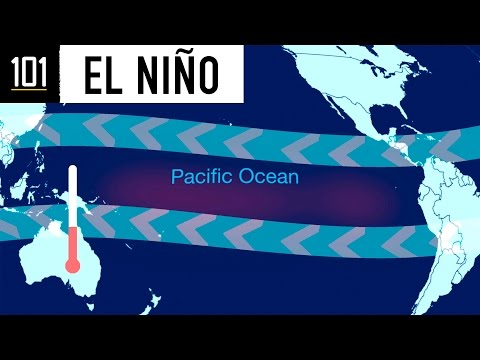

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('d6s0T0m3F8s')

### Datos de SST: HadSST

In [5]:
Reg='Nino3'
#indica el path donde tienes los datos
path='/Users/ftaucm/Desktop/curso_UCAD/data/'
#path='/users/imac/belen/python_curso_analisisdatos/analisis_multivariante/datos/'
vari ='HadISST1_sst_1870-2019.nc'


### Para leer correctamente un fichero netcdf hay que hacerlo con nc.Dataset . Utilizando el comando " .variables" (sin argumento) se ven los nombres y características de todas las variables del fichero netcdf

In [6]:
fil = nc.Dataset(path + vari)
myvar = fil.variables
myvar

{'longitude': <class 'netCDF4._netCDF4.Variable'>
 float32 longitude(longitude)
     standard_name: longitude
     long_name: Longitude
     units: degrees_east
     axis: X
 unlimited dimensions: 
 current shape = (360,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'latitude': <class 'netCDF4._netCDF4.Variable'>
 float32 latitude(latitude)
     standard_name: latitude
     long_name: Latitude
     units: degrees_north
     axis: Y
 unlimited dimensions: 
 current shape = (180,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 float64 time(time)
     standard_name: time
     long_name: Time
     units: days since 1870-01-01 00:00:00
     calendar: standard
     axis: T
 unlimited dimensions: time
 current shape = (1800,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'sst': <class 'netCDF4._netCDF4.Variable'>
 float32 sst(time, latitude, longitude)
     standard_name: sea_surface_temperature

### Usando el comando "keys" puedes ver las variables del nc

In [7]:
print(fil.variables.keys())

dict_keys(['longitude', 'latitude', 'time', 'sst'])


# Creación de índices
## Creación de series temporales de referencia (indices conocidos)
### El índice es la serie temporal que tu quieres covariar con otra

Tienes que leer las latitudes y longitudes y seleccionar la región que quieres utilizar. En este ejemplo concreto, vamos a seleccionar la región de El Niño, situada en el Pacífico ecuatorial entre las latitudes 5S y 5N y las longitudes en el rango 150 W - 90W. 
Si quieres tomar una región diferente, sólo tienes que cambiarla aquí.

NOTA: el cálculo del índice se puede hacer de varias maneras, como veremos a continuación

Traducción realizada con la versión gratuita del traductor www.DeepL.com/Translator

### Vamos a definir el índice de El Niño

In [8]:
lon = fil.variables['longitude'][:]
lat = fil.variables['latitude'][:]
sst = fil.variables['sst'][:]
nt, nlat, nlon = sst.shape
nm = 12
nysst = int(nt/nm)
lonmin,lonmax,latmin,latmax = -150, -90, -5, 5
Ni3 = sst[:,:,(lon>lonmin)&(lon<lonmax)][:,(lat>latmin)&(lat<latmax),:].mean(axis=(1,2))
Ni3 = np.reshape(Ni3,[nysst,nm])
mNi3 = Ni3.mean(axis=0)
yrsst = np.arange(1870,2020)

<ipython-input-8-ff2647e454bd>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = fil.variables['longitude'][:]
<ipython-input-8-ff2647e454bd>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat = fil.variables['latitude'][:]
<ipython-input-8-ff2647e454bd>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silenc

### ahora calculamos el índice de. El Niño que es la media de la SST en esa caja

### ahora dibujamos el índice

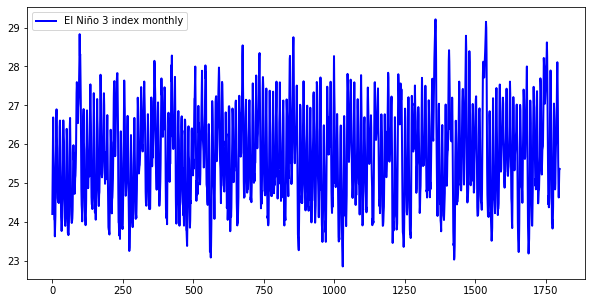

In [9]:
fig,ax = plt.subplots(figsize = (10,5))
plt.plot(np.reshape(Ni3,(1800,1)),linewidth= 2,color='Blue',label='El Niño 3 index monthly')
plt.legend()
idx=np.reshape(Ni3,(1800,1));

### de una primera inspección del índice, podemos ver:
1. tendencia
2. ciclo estacional
3. variabilidad interanual
4. variabilidad decadal

## Ciclo estacional
El ciclo estacional es la media de las variaciones anuales de una determinada variable a lo largo de un periodo de años.
Cada mes se promedia durante un periodo de años mes.
Tanto el ciclo estacional de la media como el de la variabilidad son interesantes. El asociado a la variabilidad nos da información sobre los meses en los que hay más diferencia la variabilidad nos proporciona información acerca de los meses en los que hay más diferencias entre años, y suele elegirse para analizar las causas de la variabilidad


Text(0.5, 1.0, 'Ciclo estacional de la desviación Nino3')

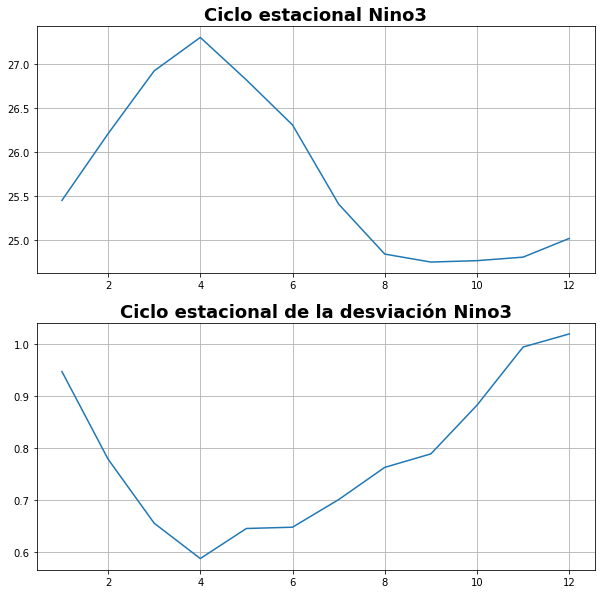

In [10]:
fig,ax=plt.subplots(2,1,figsize = (10,10))
ax[0].plot(range(1,nm+1),Ni3.mean(axis=0))
ax[1].plot(range(1,nm+1),Ni3.std(0))
#ni34 = (ni34tot[(yrsst>=yrmin)&(yrsst<=yrmax),0:3]).mean(axis=1)
ax[0].grid()
ax[1].grid()
ax[0].set_title('Ciclo estacional '+Reg,fontsize=18,weight='bold')
ax[1].set_title('Ciclo estacional de la desviación '+Reg,fontsize=18,weight='bold')


## Ahora calculamos las anomalía
Recuerda que para hacer el mapa de regresion las anomalías se estandarizan
Para el caso de El Niño tomamos enero y febrero porque son los meses de mayor variabilildad

In [11]:
A=Ni3.reshape(nysst,nm)
#calculo las anomalias estandarizadas
Nino2_ef=(A[:,[0,1]].mean(1)-Ni3.reshape(nysst,nm)[:,[0,1]].mean(1).mean(0))/Ni3.reshape(150,12)[:,[0,1]].mean(1).std(0)

Text(0.5, 1.0, 'Evolution of Nino3 index ')

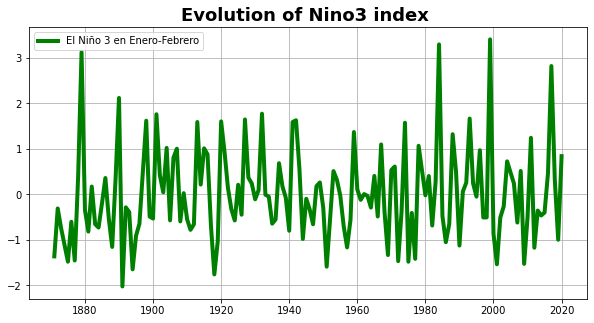

In [12]:
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(range(1871,2021),Nino2_ef,linewidth= 4,color='green',label='El Niño 3 en Enero-Febrero')
ax.grid()
ax.legend()
ax.set_title('Evolución del índice de '+Reg,fontsize=18,weight='bold')


##Influencia de la tendencia y filtrado

Toda serie temporal puede tener
1) tendencia
2) variabilidad interanual
3) variabilidad decadal 

Con el comando signal.detrend se resta el ajuste lineal de los datos para eliminar la tendencia. Utilizando el filtro Butterworth, la serie temporal se separa en la baja y la alta frecuencia

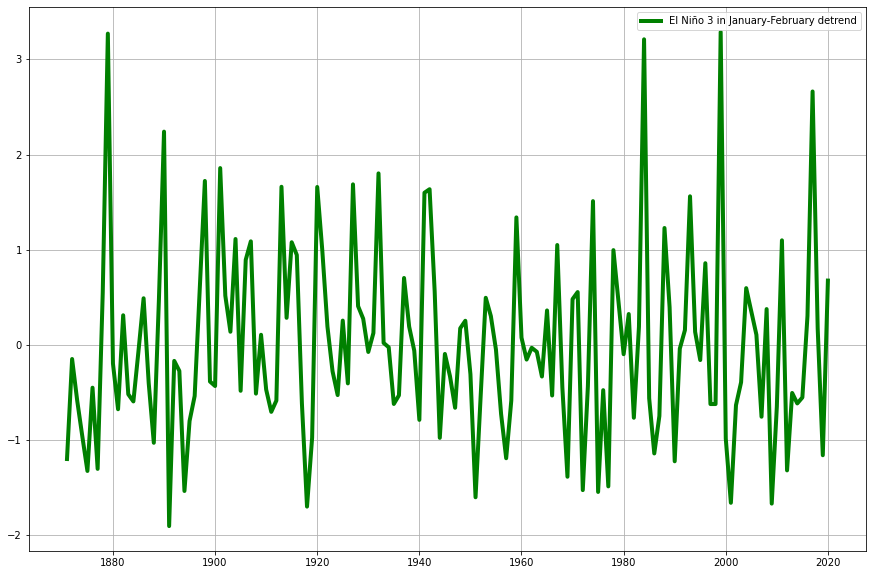

In [13]:
nino_d=signal.detrend(Nino2_ef)
fig=plt.figure(figsize=(15,10))
ax=plt.plot(range(1871,2021),nino_d,linewidth= 4,color='green',label='El Niño 3 in January-February detrend')
ax=plt.grid()
ax=plt.legend()

### Como es interesante distinguir entre la baja y la alta frecuencia, filtramos

Vamos a utilizar el filtro Butterworth con una frecuencia de corte definida como fc=2dT/T, siendo dt el intervalo de muestreo y T el periodo que queremos filtrar, en las mismas unidades que dt. El filtro Butter tiene la frecuencia normalizada de forma que 1 corresponde a la frecuencia máxima fmax=FNyquist y Wn=fc2 Tomamos n = 10 como orden nominal del filtro. Si queremos aplicar un filtro de 12 años con datos con intervalo de tiempo de muestra de 1 año¡(dt=1), entonces, wn=2dt/T=21/12=1/6;


In [14]:
nyc=13
n=10
Wn=1/nyc
bl,al=signal.butter(n, Wn, btype='low', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
low = signal.filtfilt(bl,al,nino_d)
bh,ah=signal.butter(n, Wn, btype='high', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
high = signal.filtfilt(bh,ah,nino_d)

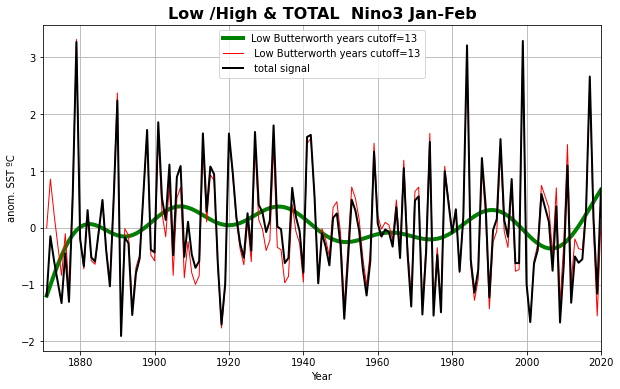

In [15]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('Low /High & TOTAL  Nino3 Jan-Feb',fontsize=16,weight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('anom. SST ºC')
ax.plot(range(1871,2021),low,linewidth= 4,color='green',label='Low Butterworth years cutoff='+str(nyc))
ax.plot(range(1871,2021),high,linewidth= 1,color='red',label=' Low Butterworth years cutoff='+str(nyc))
ax.plot(range(1871,2021),nino_d,linewidth= 2,color='black',label=' total signal')
ax.set_xlim([1870,2020])
ax.legend()
ax.grid()

# Calculamos los mapas de correlacion y regresión y la significación estadística
### La primera cosa que hay que hacer es cargar el otro campo con el que queremos trabajar
en este caso vamos a ver el mapa de correlacion y regresión con la SST

In [16]:
sst_all=fil.variables['sst'][:,:,:]
sst_all.shape

<ipython-input-16-6029af71ec96>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sst_all=fil.variables['sst'][:,:,:]


(1800, 180, 360)

### Es importante ver que todo va bien, asi que chequeemos los datos

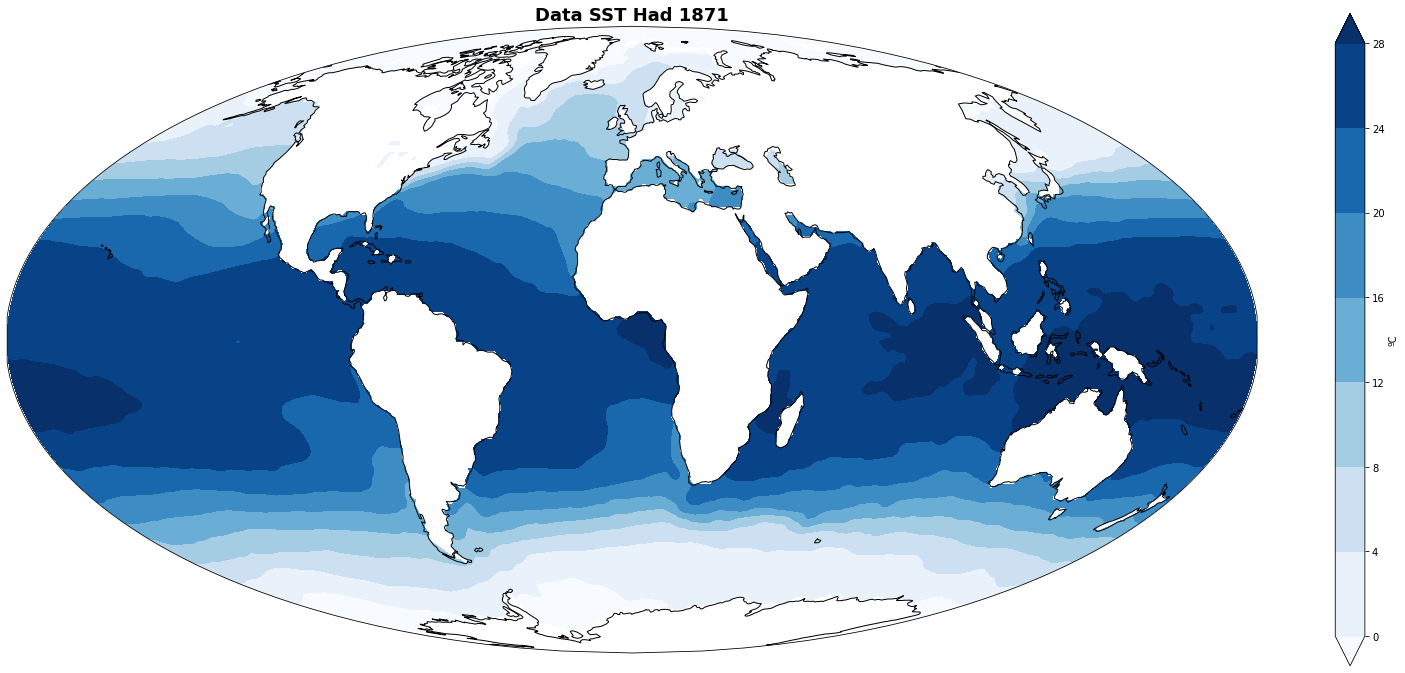

In [17]:
#dibuja solo un mapa para ver que todo va bien
fig = plt.figure(figsize=(28,12)) 
i=1
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide(0))
A=sst_all[i,:,:]
im = ax.contourf(lon,lat,A,cmap='Blues',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax,label='ºC') #Para la barra de colores
ax.grid()
ax.set_title('Data SST Had 187'+str(i),fontsize=18,weight='bold')
ax.set_ylabel('Lat',fontsize=18)
ax.set_xlabel('lon',fontsize=18);
plt.show(i)
time.sleep(2)


### Organizamos correctamente los datos en años, meses, espacio y promediamos los meses que nos interesan (enero y febrero en nuestro caso)

In [18]:
sst_ef=sst_all.reshape(nysst,nm,len(lat)*len(lon))[:,[0,1],:].mean(1)


## Calculamos las anomalías pero no estandarizamos las SST


Organizamos correctamente los datos en años, meses, espacio y promediamos los meses que nos interesan (enero y febrero en nuestro caso)


In [19]:
sst_ef=sst_ef-sst_ef.mean(0)

### Para ejecutar la funcion IndexRegression los datos han de estar organizados en  (espacio, tiempo ) 

In [20]:
sst_ef.shape
field=np.transpose(sst_ef)
field.shape

(64800, 150)

### Llamo "index" a la serie de El Niño en enero-febrero

In [21]:
#Index=Nino2_ef;
Index=np.transpose(nino_d)
low=np.transpose(low)
high=np.transpose(high)
low.shape

(150,)

In [22]:
[correD,pvalueD,csig,reg,reg_sig]=IndexRegression(field,Index[:],0.01)
[correD_l,pvalueD_l,csig_l,reg_l,reg_sig_l]=IndexRegression(field,low[:],0.01)
[correD_h,pvalueD_h,csig_h,reg_h,reg_sig_h]=IndexRegression(field,high[:],0.01)


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


### Ahora trazo mis mapas, que son las variables de salida de la función Indexregresion, pero reorganizo la dimensión espacial de los datos en lat y lon

Text(0.5, 1.0, 'Correlation map for the Index in the Niño3 region in January-February- and  SST  from Had 1870-2020')

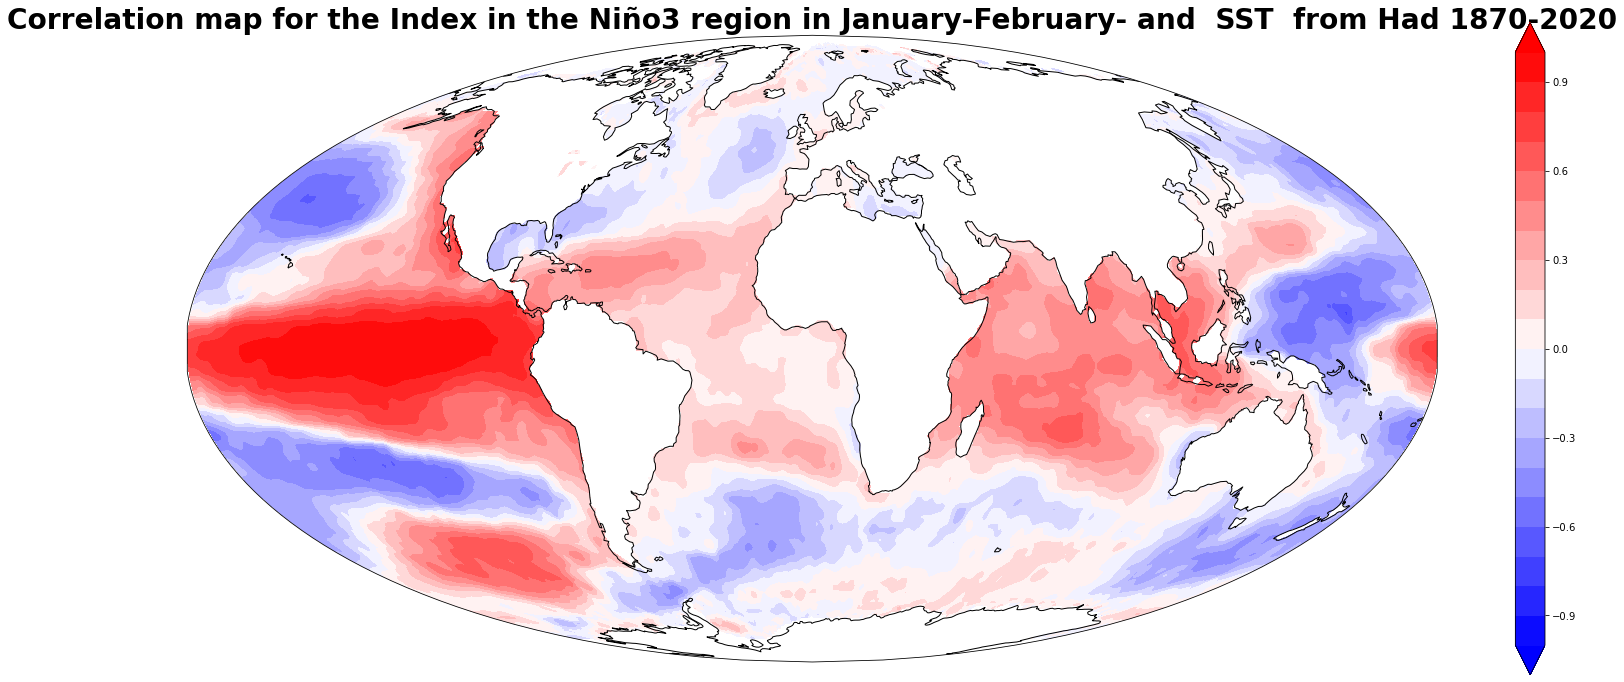

In [23]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide(0))
im = ax.contourf(lon,lat,correD.reshape(len(lat),len(lon)),levels=np.arange(-1,1.1,0.1),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Correlation map for the Index in the Niño3 region in January-February- and  SST  from Had 1870-2020',fontsize=28,weight='bold')


### Podemos exportar la figura en png 

In [24]:
plt.savefig('Correlation_map_Nino3EF_1870_2020.pdf',papertype='a4',format='pdf')

<ipython-input-24-87f3131301e3>:1: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('Correlation_map_Nino3EF_1870_2020.pdf',papertype='a4',format='pdf')


<Figure size 432x288 with 0 Axes>

### Dibujo el p-value para ver que la significacion es correcta

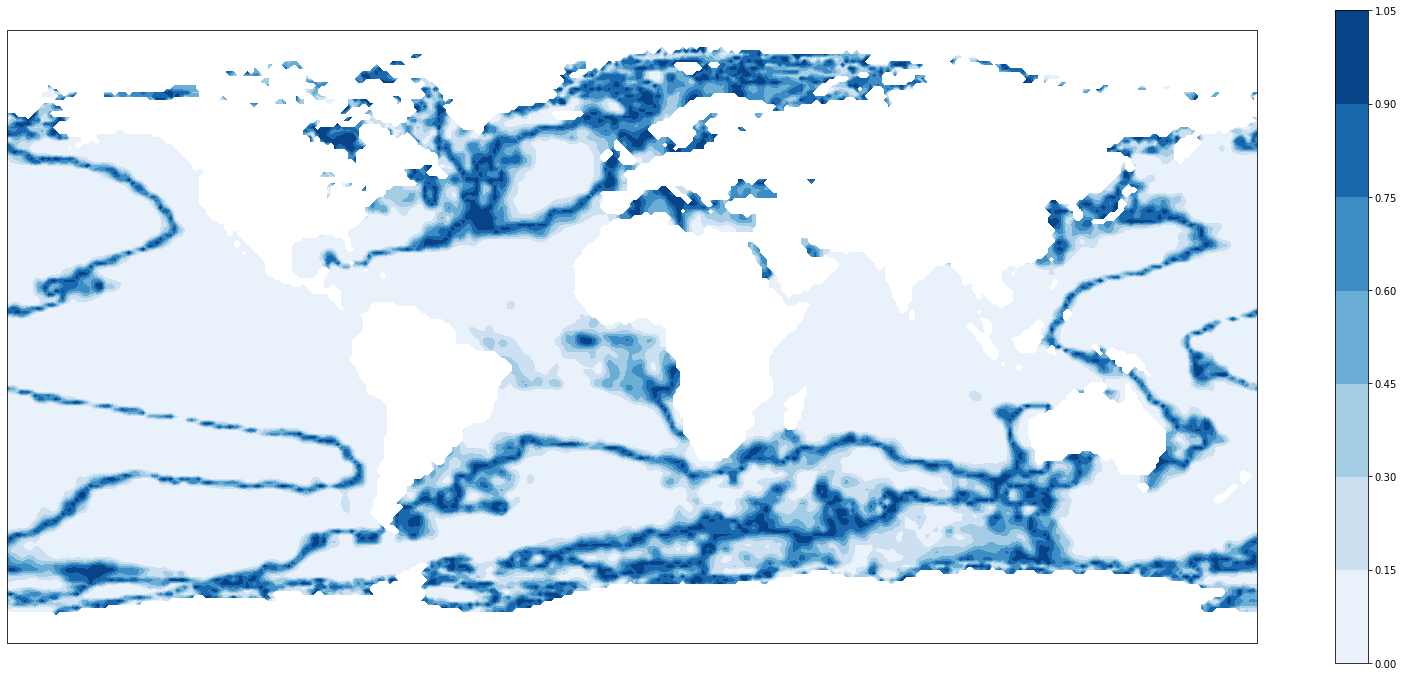

In [25]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide(0))
im = ax.contourf(lon,lat,pvalueD.reshape(len(lat),len(lon)),cmap='Blues')
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores

### Ahora combinamos los mapas anteriores para dibujar el mapa de regresion donde la correlacion es significativa

<ipython-input-26-e780def1899a>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('Correlation_map_sig_Nino3JF_1870_2020.pdf',papertype='a4',format='pdf')


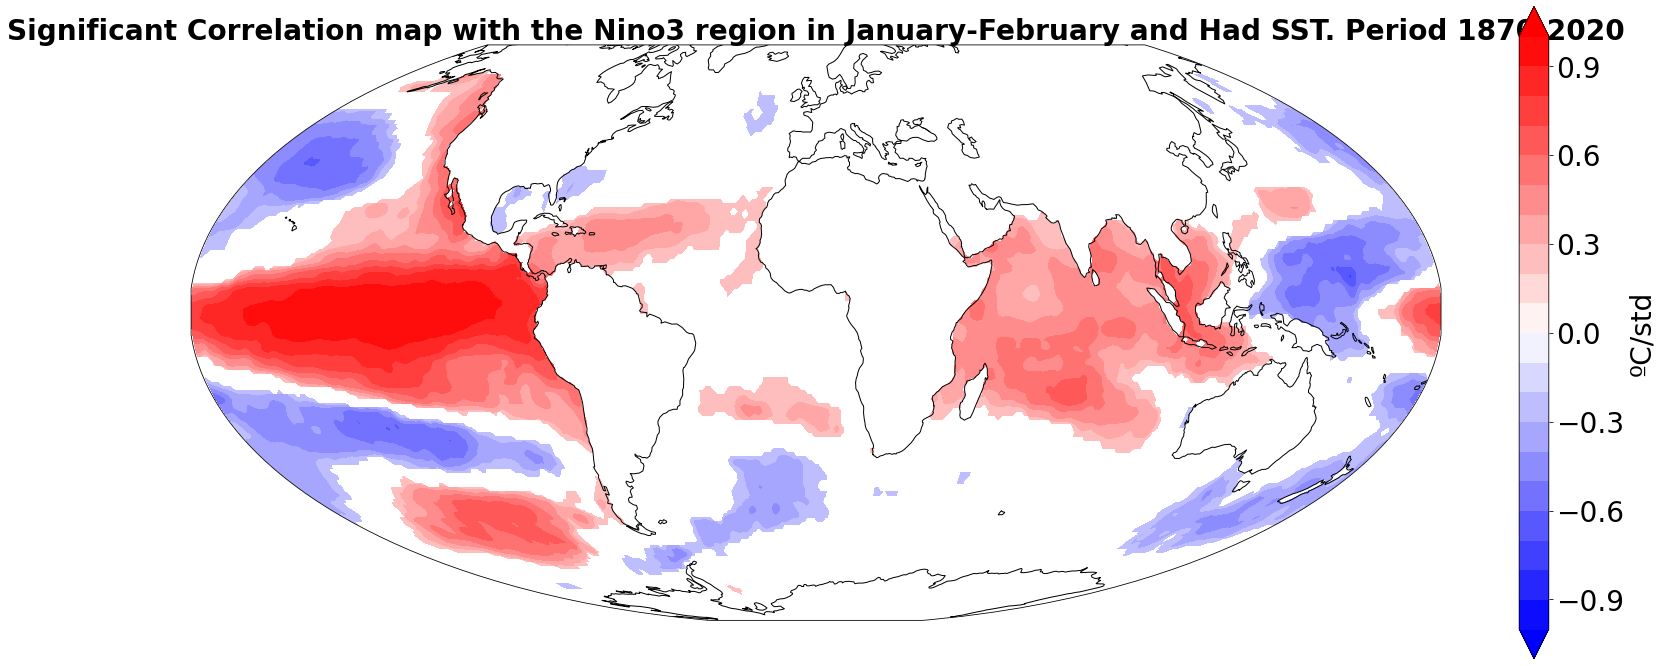

In [26]:
#ahora dibujamos el mapa de correlación sólo donde es significativo
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide(0))
im = ax.contourf(lon,lat,csig.reshape(len(lat),len(lon)),cmap='bwr',levels=np.arange(-1,1.1,0.1),extend='both',transform = ccrs.PlateCarree())
ax.coastlines()
cbar=fig.colorbar(im,ax=ax) #Para la barra de colores
cbar.ax.tick_params(labelsize=28)
cbar.set_label('ºC/std',fontsize=28)
ax.set_title('Significant Correlation map with the Nino3 region in January-February and Had SST. Period 1870-2020',fontsize=28,weight='bold')
plt.savefig('Correlation_map_sig_Nino3JF_1870_2020.pdf',papertype='a4',format='pdf')

## Ahora dibujamos el mapa de regresion y el mapa de regresion significativo
Next, we calculate the regression map (covariance map if the index is not standardized). If both, the field and the index are standardized, we have the correlation map
Remember that the regression map between a time series and a field is equivalent to project a field in the direction of an index .  We can take 2 different varibles, for example: index of El Niño with SLP
See how El Niño impact in different fields, as Z500, precipitation etc...you can try!!!

<ipython-input-27-8d29aac864d1>:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('Regression_Nino3JF_1870_2020.pdf',papertype='a4',format='pdf')


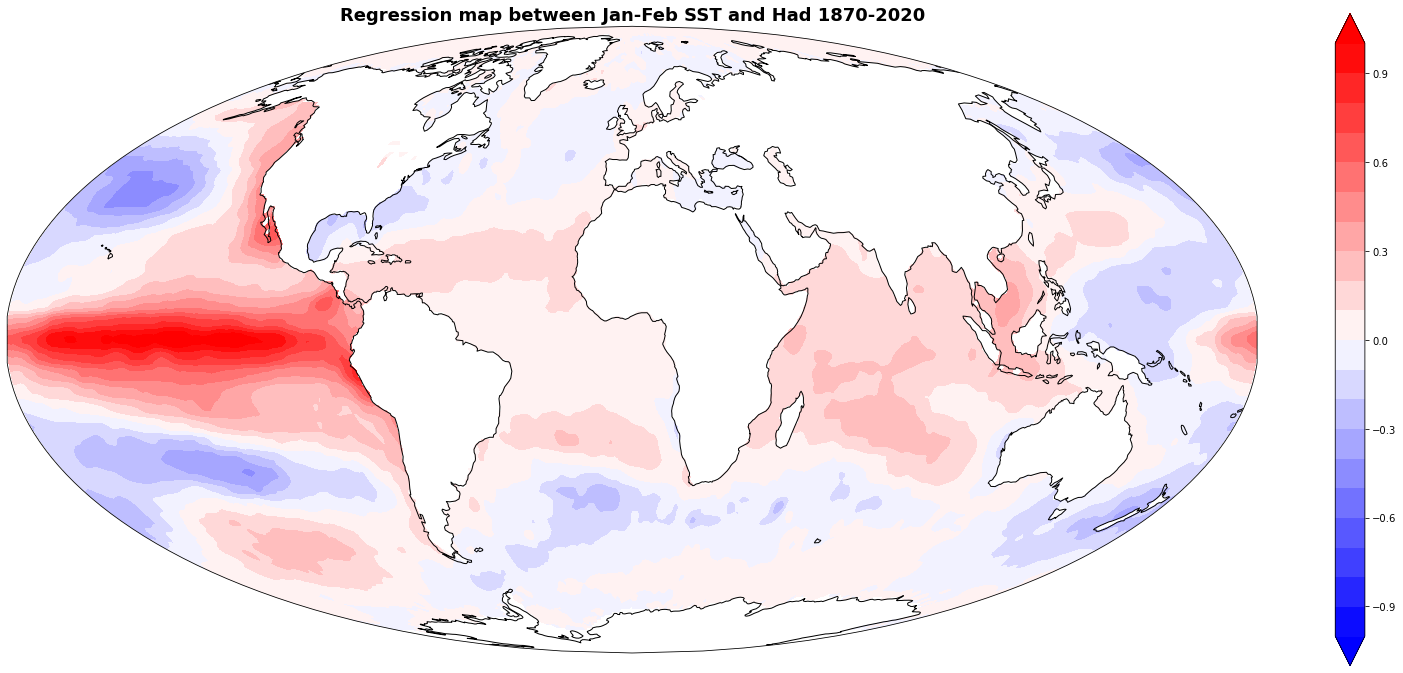

In [27]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide(0))
im = ax.contourf(lon,lat,reg.reshape(len(lat),len(lon)),cmap='bwr',levels=np.arange(-1,1.1,0.1),extend='both',transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Regression map between Jan-Feb SST and Had 1870-2020',fontsize=18,weight='bold')
plt.savefig('Regression_Nino3JF_1870_2020.pdf',papertype='a4',format='pdf')

### Finalmente hacemos lo mismo que antes para dibujar donde es significativo

<ipython-input-28-48cb5decfccd>:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('Mapa_Regresion_Sig_Nino3EF_1870_2020.pdf',papertype='a4',format='pdf')


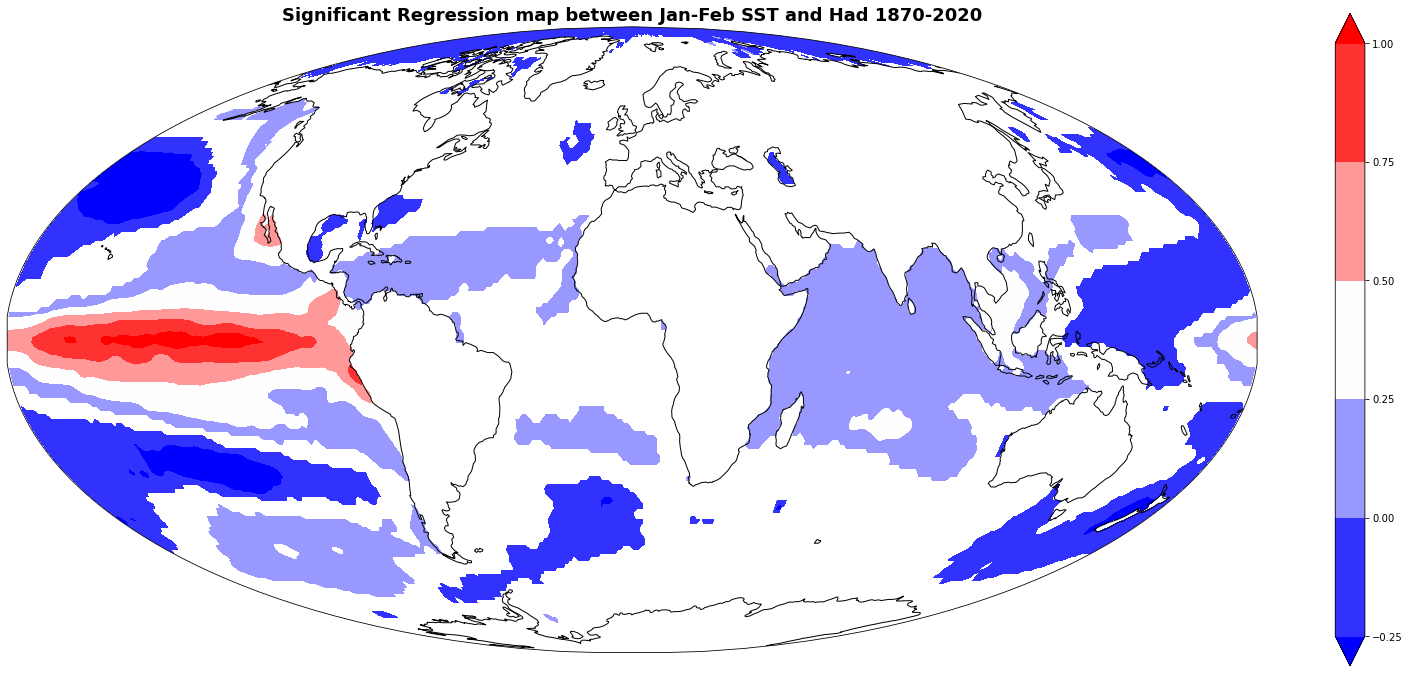

In [28]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide(0))
im = ax.contourf(lon,lat,reg_sig.reshape(len(lat),len(lon)),cmap='bwr',extend='both',transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Significant Regression map between Jan-Feb SST and Had 1870-2020',fontsize=18,weight='bold')
plt.savefig('Mapa_Regresion_Sig_Nino3EF_1870_2020.pdf',papertype='a4',format='pdf')

## Ahora separamos en alta y baja frecuencia

<ipython-input-29-955a3fd25773>:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('significant_regression_map_Nino3EF_1870_2020_LOW.pdf',papertype='a4',format='pdf')
<ipython-input-29-955a3fd25773>:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('Regress_map_Sig_Nino3JF_1870_2020_HIGH.pdf',papertype='a4',format='pdf')


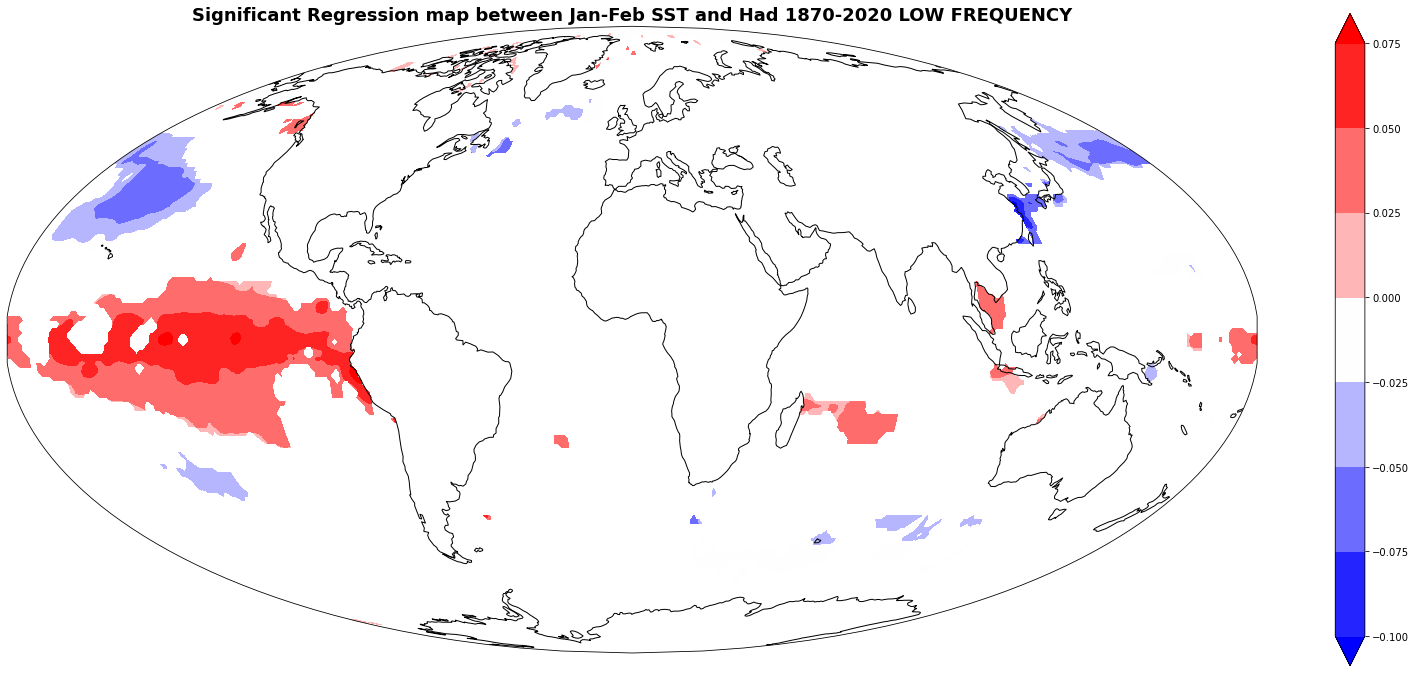

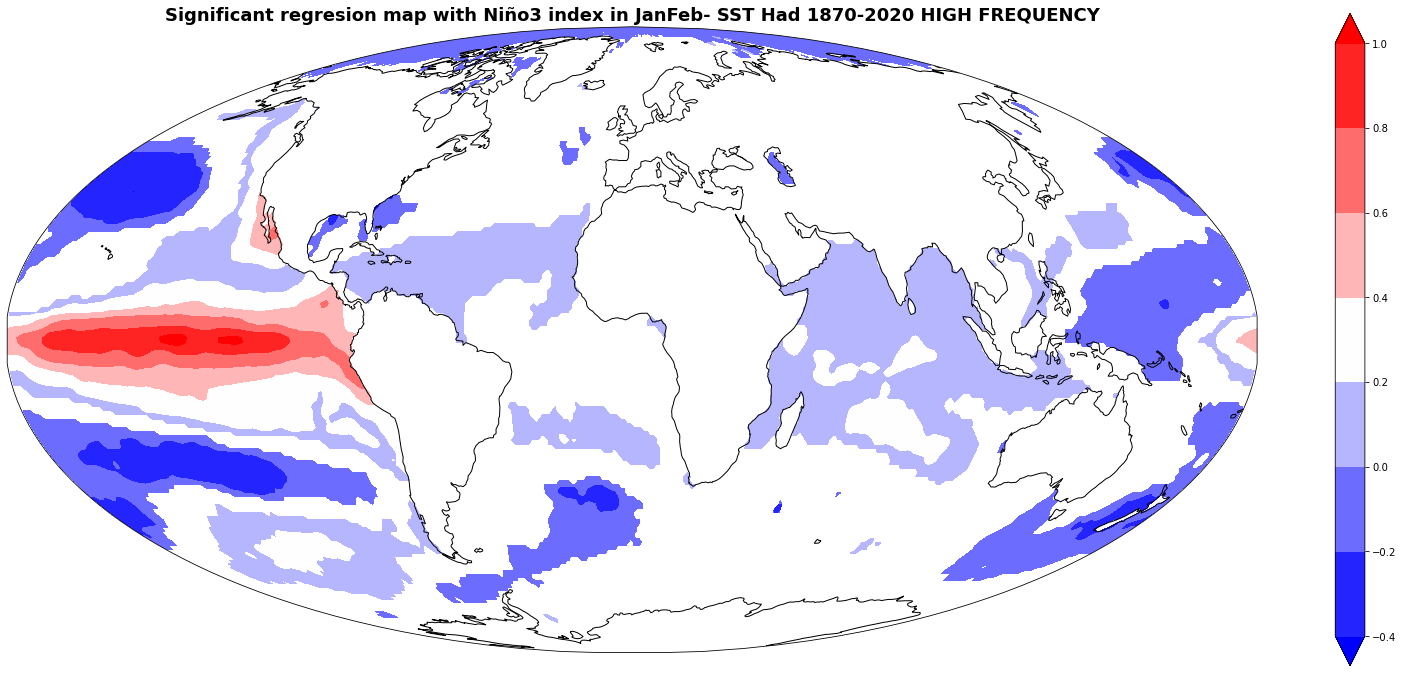

In [29]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide(0))
im = ax.contourf(lon,lat,reg_sig_l.reshape(len(lat),len(lon)),cmap='bwr',extend='both',transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Significant Regression map between Jan-Feb SST and Had 1870-2020 LOW FREQUENCY',fontsize=18,weight='bold')
plt.savefig('significant_regression_map_Nino3EF_1870_2020_LOW.pdf',papertype='a4',format='pdf')

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide(0))
im = ax.contourf(lon,lat,reg_sig_h.reshape(len(lat),len(lon)),cmap='bwr',extend='both',transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Significant regresion map with Niño3 index in JanFeb- SST Had 1870-2020 HIGH FREQUENCY',fontsize=18,weight='bold')
plt.savefig('Regress_map_Sig_Nino3JF_1870_2020_HIGH.pdf',papertype='a4',format='pdf')

 Podemos concluir que, aunque el Niño es basicamente un fenómeno de alta frecuencia, tiene una componente decadal que es la llamada IPO